# IDENTIFICATION USING BOTH SURROGATE MODELS - COARSE AND FINE

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [3]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model


#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

sys.path.append('../../tests/Xaccelerometer_geometric/models')




Ray module not found. Multiprocessing features are not available


#### Decide sample to use for experimental data

In [4]:
sample = 110 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_"+str(sample)

#### Set Bayesian Identification Parameters

In [6]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 1000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2


#### Load Surrogate Models

Load fine model 

In [7]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Load Fine model 
# Initialize and load models for both configurations
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])
# Define forward and gradient functions for the first configuration
fine_model = create_forward_model_function(data_processor_I, model_I)

Load coarse model 

In [8]:
# Import the function coarse_model
from coarse_model import *

num_samples = 640
num_parameters = 3
num_coarse_values = 75
# Define the neural network model
model_lowfidelity_NN = Sequential([
        Dense(150,input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])
# Load the model
model_lowfidelity_NN = load_model('./models/model_LF_NN_oo3.keras')
model_lf = create_model_LF_NN_oo3_opt()

/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


load the data 

In [9]:
# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

### Define Priors and Likelyhoods

 Define a custom Uniform random variable class

In [10]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):   
        if  self.pdf(x)==0:
            return -np.inf
        else:
            return np.log(self.pdf(x))
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [11]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(data_processor_I.time))
y_distr_fine = tda.GaussianLogLike(y_observed, cov_likelihood) 

#points = np.linspace(0,0.0015-1e-5,150)
#phi = lambda t: np.abs(np.cos(2*np.pi*2500*t)) if t < 2.25/2500 and t > 0.25/2500 else 0
#coeff = [1+10*phi(t-1e-5*10) for t in points]
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10)

### Define a Posterior

In [12]:
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]



#### Perform least square optimization for each starting point

In [13]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=fine_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")

# covariance_matrix = np.eye(3)*(np.diag(covariance_matrix))
print('\nWe are using the following covariance matrix\n', covariance_matrix)


Real Params:  [ 0.317228  0.314022 30.854021]
Optimized Params 1: [ 0.31732946  0.31468629 30.79105531]
Optimized Params 2: [ 0.31736142  0.31463067 30.79916484]
Optimized Params 3: [ 0.3173275   0.3147029  30.78917739]
Optimized Params 4: [ 0.3173685   0.31464356 30.79832948]
Optimized Params 5: [ 0.31737245  0.31462614 30.80043536]

We are using the following covariance matrix
 [[ 8.85842978e-05 -5.69923001e-05  1.23037086e-02]
 [-5.69923001e-05  1.41687867e-04 -1.88520180e-02]
 [ 1.23037086e-02 -1.88520180e-02  2.84966957e+00]]


Set up the proposal

In [14]:
# Adaptive Metropolis
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.075)
covariance_matrix
# get the maximum a posteriori point / 
#MAP = tda.get_MAP(my_posterior_fine)
#print(MAP)

array([[ 8.85842978e-05, -5.69923001e-05,  1.23037086e-02],
       [-5.69923001e-05,  1.41687867e-04, -1.88520180e-02],
       [ 1.23037086e-02, -1.88520180e-02,  2.84966957e+00]])

#### Do Metropolis Hastings Sampling

In [61]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
# Iterate over each initial guess to set up and run the Markov chain sampler\n",
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, 
                             iterations=3300, n_chains=1,
                               initial_parameters=initial_guess, 
                           subsampling_rate = 3) #adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(300, None, 3), groups="posterior")
    # Append the samples to the list\n",
    samples_mh.append(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples\n",
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")

# Computing diagnostics and collecting results\n",
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')) ) 
# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  



Sampling chain 1/1


Running chain, α_c = 0.690, α_f = 0.43: 100%|██████████| 3300/3300 [00:15<00:00, 211.24it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 380.3
    Offset     float64 8B 307.7
    Thickness  float64 8B 299.2 

Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.43: 100%|██████████| 3300/3300 [00:16<00:00, 203.97it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 318.3
    Offset     float64 8B 341.0
    Thickness  float64 8B 351.4 

Sampling chain 1/1


Running chain, α_c = 0.693, α_f = 0.46: 100%|██████████| 3300/3300 [00:15<00:00, 214.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 380.8
    Offset     float64 8B 340.1
    Thickness  float64 8B 334.7 

Sampling chain 1/1


Running chain, α_c = 0.650, α_f = 0.42: 100%|██████████| 3300/3300 [00:15<00:00, 217.36it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 365.8
    Offset     float64 8B 401.6
    Thickness  float64 8B 388.1 

Sampling chain 1/1


Running chain, α_c = 0.690, α_f = 0.53: 100%|██████████| 3300/3300 [00:15<00:00, 214.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 430.6
    Offset     float64 8B 337.1
    Thickness  float64 8B 350.4 

Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.0
    Offset     float64 8B 1.001
    Thickness  float64 8B 1.001


# Diagnostics 

In [26]:
# Plot trace of the first set of samples
#idata = samples_mh[2].sel(draw=slice(MCMC_SETTINGS['Nb'], None,MCMC_SETTINGS['Nt']))
idata = samples_mh[0]
az.plot_trace(idata)
plt.tight_layout()
plt.show()


NameError: name 'samples_mh' is not defined

Let's compare the prediction of the mean parameter combination and the experimental signal

In [39]:
def plot_results(time, y_true, y_obs, model, samplesMH, REAL_COLOR='red', LINE_WIDTH=1.5):
    plt.figure()
    plt.plot(1e3*time, y_true, c=REAL_COLOR, label='Real', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(np.mean(samplesMH, axis=1)), 'green', label='Pred', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, y_obs, '.-b', label='Noisy Signal', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(x_true), 'black', label = 'True parameters')
    plt.xlabel('Time [ms]')
    plt.ylabel(r'$\Delta C$ [fF]')
    plt.title(f'Overetch = {np.mean(samplesMH, axis=1)[0]:.4f}μm; Offset = {np.mean(samplesMH, axis=1)[1]:.4f}μm; Thickness = {np.mean(samplesMH, axis=1)[2]:.4f}μm', fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

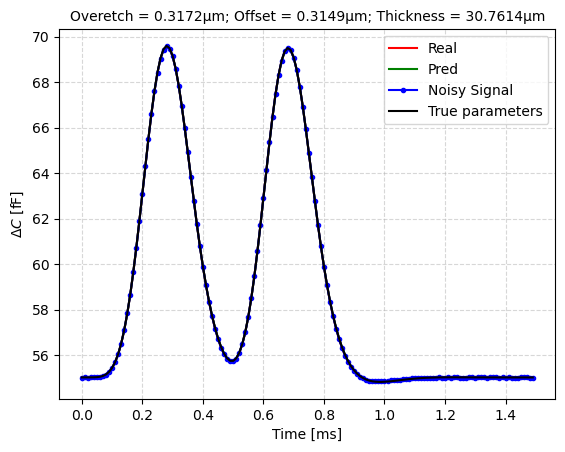

In [41]:
# Plotting and data collection
#data = az.convert_to_dataset
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, model_lf, data)

Finally, let's look at the parameters distribution

In [42]:
def plot_parameter_distribution(parameter_samples, x_true, parameter_name):
    plt.figure()
    kernel_density = gaussian_kde(parameter_samples)
    x_range = np.linspace(np.min(parameter_samples), np.max(parameter_samples), 1000)
    plt.plot(x_range, kernel_density(x_range), label='Density', linewidth=2)
    plt.axvline(x_true, color='red', label='Exact', linestyle='-', linewidth=2)
    mean, mode = np.mean(parameter_samples), x_range[np.argmax(kernel_density(x_range))]
    plt.axvline(mean, color='green', label='Mean', linestyle='--', linewidth=2)
    plt.axvline(mode, color='blue', label='Mode', linestyle='--', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples, [2.5, 97.5])
    plt.fill_between(x_range, 0, kernel_density(x_range), where=((x_range >= lower_bound) & (x_range <= upper_bound)), alpha=0.3, color='gray', label='95% C.I.')
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

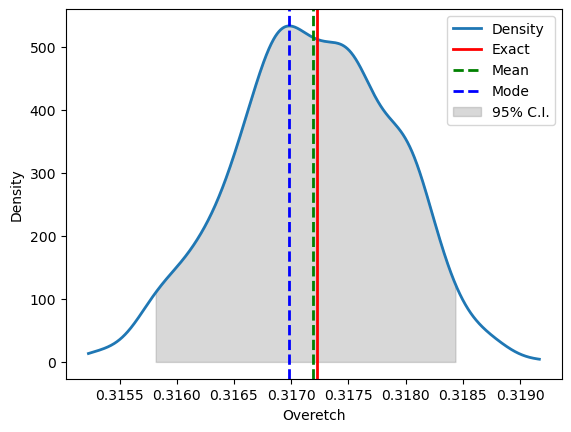

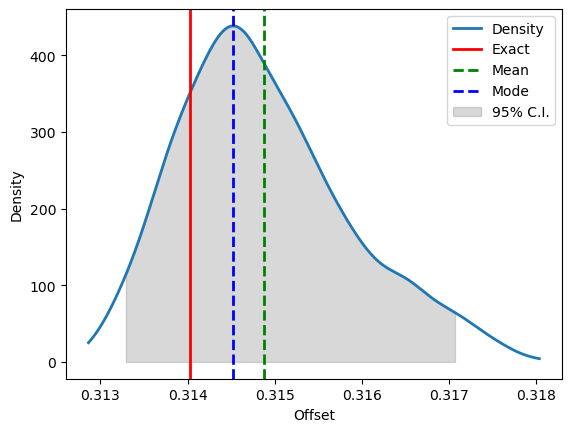

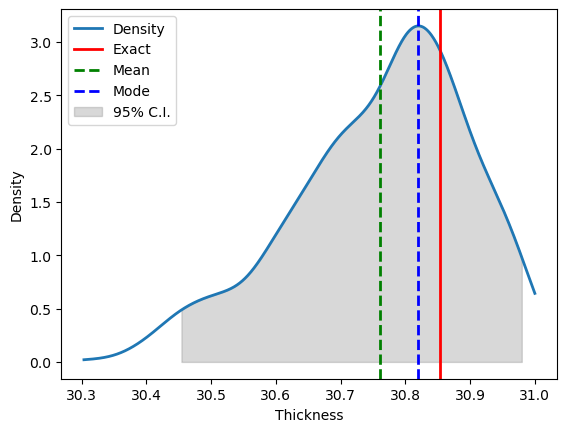

In [43]:
for j in range(3):
    plot_parameter_distribution(data[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

# Post Processing Plots

This section generates the plots in the paper.

In [ ]:
from plotsPaper import *
samples = np.load(OUTPUT_FILENAME+'.npy')

##### Histograms of the geometric parameters

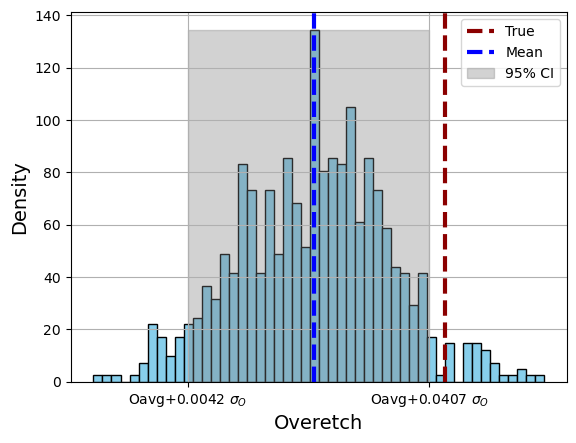

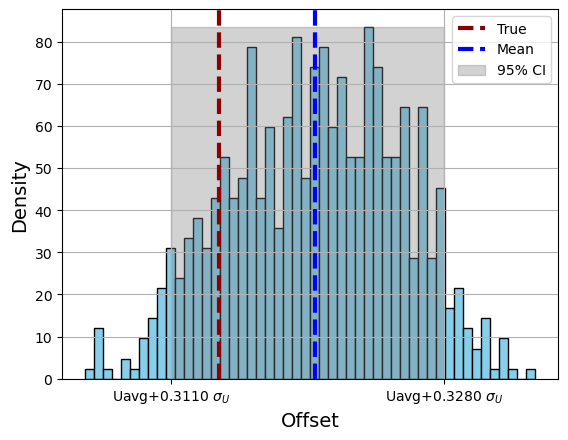

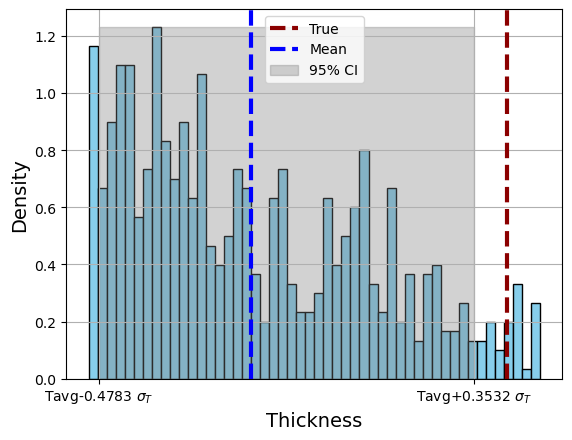

In [ ]:
plot_histograms(samples, x_true)

ciao


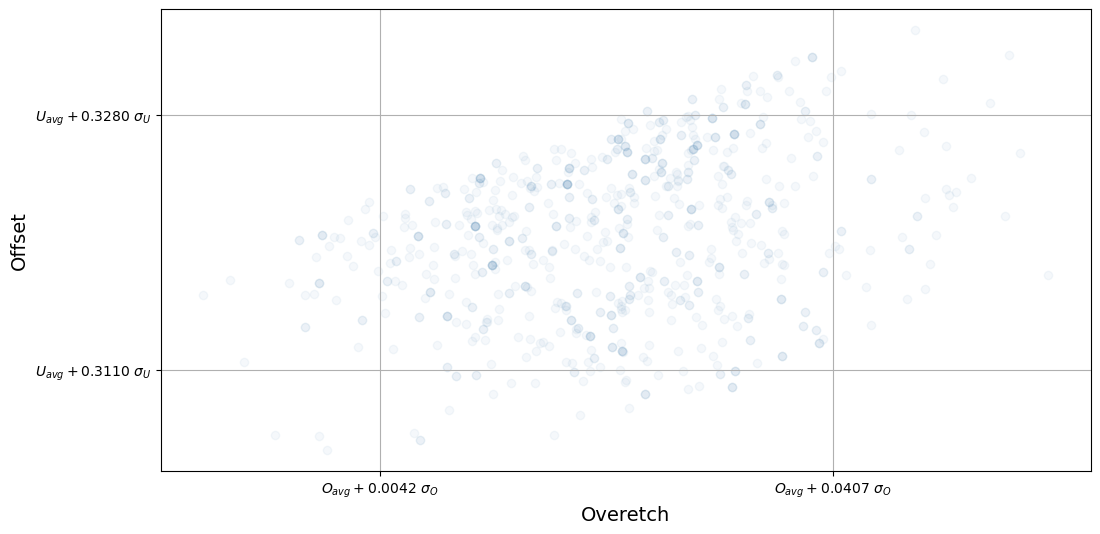

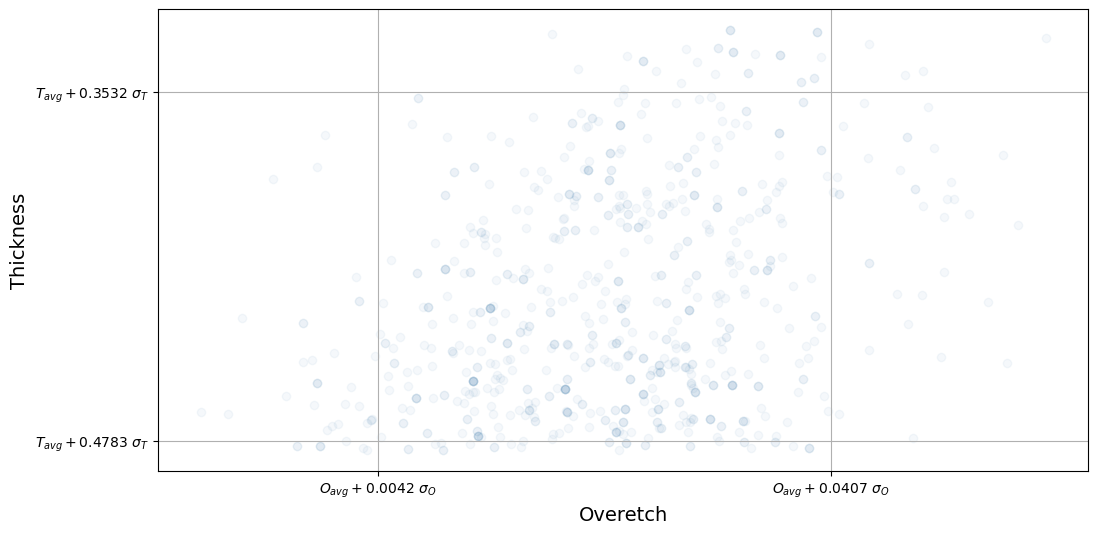

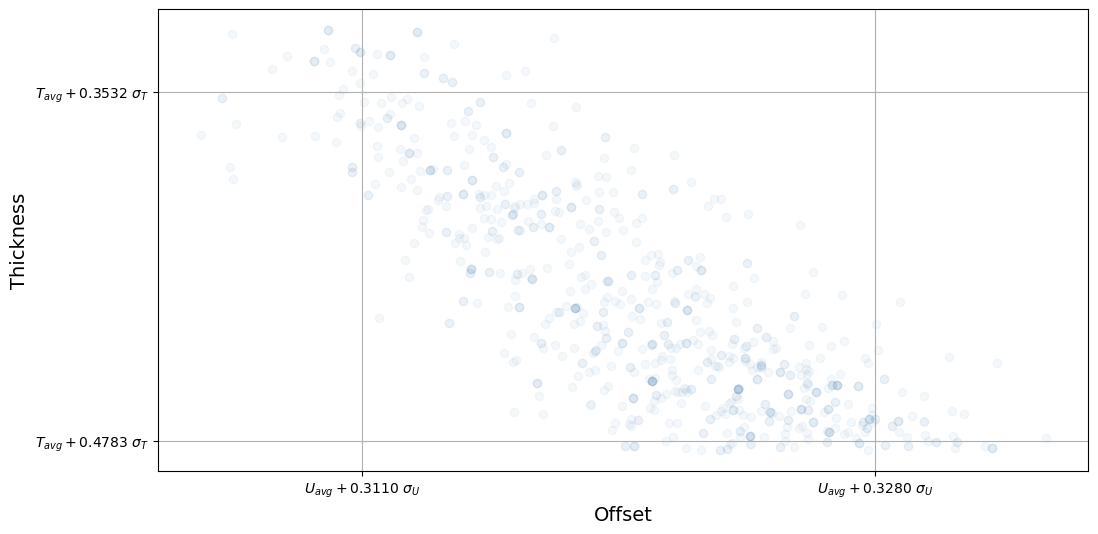

In [ ]:
plot_scatter(samples)

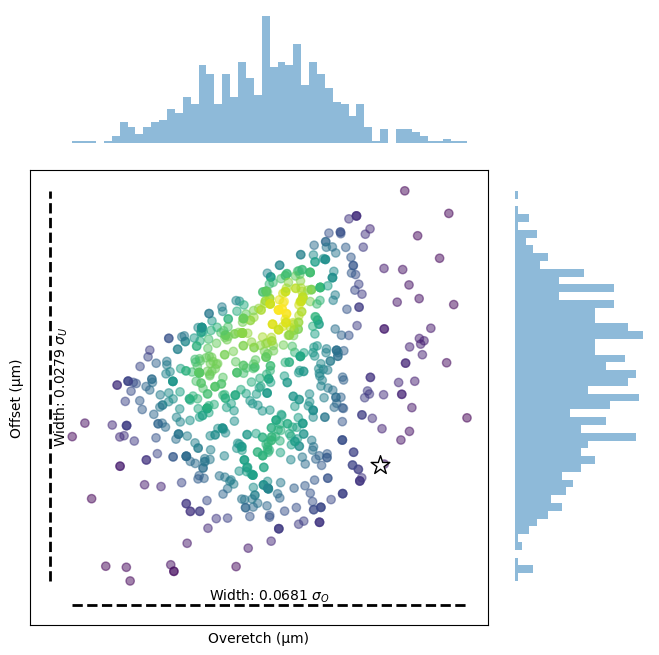

In [ ]:
plot_density_scatter(samples, x_true, sigma_values=(0.2, 0.5))  # Adjust sigma values as needed

# EFFICIENCY COMPARISON 

In [39]:
# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
ESS_values = []
ESS_values_fine = []

for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=3300, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = 3)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(100, None, 3), groups="posterior")
    # Compute the Effective Sample Size (ESS) 
    ess = az.ess(idata)
    ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])
    
end_0 = timeit.default_timer() 

my_proposal_fine =  tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.1)
start_1 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior_fine, my_proposal_fine, 
                         iterations=6000, n_chains=1,
                           initial_parameters=initial_guess)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(1000, None, 5), groups="posterior")
    # Compute the Effective Sample Size (ESS)",
    ess = az.ess(idata)
    ESS_values_fine.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])
    
end_1 = timeit.default_timer() 

print('Time MDA', (end_0-start_0))
print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values)) )
print('Time only fine', (end_1 - start_1))
print('Time/ESS fine',(end_1-start_1)/(5*np.mean(ESS_values_fine, axis = 0)) )
print('\nThe speedup coefficient is:', (end_1 - start_1)/(end_0-start_0))



Sampling chain 1/1


Running chain, α_c = 0.653, α_f = 0.33: 100%|██████████| 3300/3300 [00:10<00:00, 310.24it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.683, α_f = 0.27: 100%|██████████| 3300/3300 [00:10<00:00, 321.42it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.637, α_f = 0.34: 100%|██████████| 3300/3300 [00:10<00:00, 318.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.690, α_f = 0.50: 100%|██████████| 3300/3300 [00:10<00:00, 317.84it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.700, α_f = 0.35: 100%|██████████| 3300/3300 [00:10<00:00, 320.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.30: 100%|██████████| 6000/6000 [00:18<00:00, 333.00it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.35: 100%|██████████| 6000/6000 [00:17<00:00, 341.62it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:17<00:00, 342.58it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.30: 100%|██████████| 6000/6000 [00:17<00:00, 335.43it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.36: 100%|██████████| 6000/6000 [00:17<00:00, 345.93it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time MDA 52.061495207977714
Time/ESS MDA 0.14614119532217604
Time only fine 88.43510983401211
Time/ESS fine [0.20582195 0.23594194 0.22105548]

The speedup coefficient is: 1.6986663460341922


In [37]:
np.mean([[1,2,3],[2,3,4]], axis = 0)

array([1.5, 2.5, 3.5])

# Choose the optimal parameters 

In [ ]:
N_iter = 4000
N_subsampl = 3
scale = 1


MDA model 

In [ ]:
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)

samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=N_iter, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = N_subsampl)

idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])  
idata = idata.sel(draw=slice(200, None,5), groups="posterior")
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", az.ess(idata),"\n")

Sampling chain 1/1


Running chain, α_c = 0.013, α_f = 0.00: 100%|██████████| 4000/4000 [00:07<00:00, 536.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 12.58
    Offset     float64 8B 9.55
    Thickness  float64 8B 9.437 



Only Fine model 

In [ ]:
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)

samples = tda.sample(my_posterior_fine, my_proposal, 
                         iterations=6000, n_chains=1,
                           initial_parameters=initial_guess)
idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])  
idata = idata.sel(draw=slice(1000, None, 100), groups="posterior")
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", az.ess(idata),"\n")

Sampling chain 1/1


Running chain, α = 0.00: 100%|██████████| 6000/6000 [00:27<00:00, 214.49it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 50.0
    Offset     float64 8B 50.0
    Thickness  float64 8B 50.0 



/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


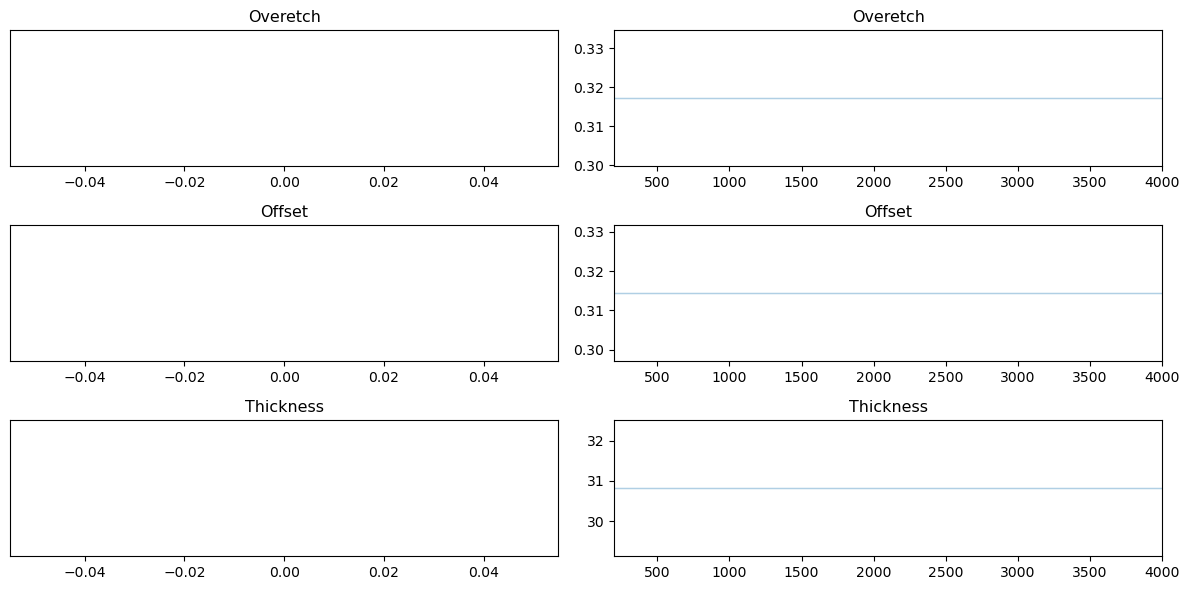

In [ ]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

# Gridsearch for optimal parameters

In [ ]:
subsampling_rate_values = [1, 3, 5 , 10 , 20 , 30 , 100]
scaling_values = [0.01, 0.03, 0.05 , 0.075, 0.09, 0.1, 0.25, 0.5, 0.75, 1 ]

In [ ]:
M = np.zeros((len(subsampling_rate_values), len(scaling_values)))


for index1, ssr in enumerate(subsampling_rate_values):
    for index2, scale in enumerate(scaling_values): 
        # Adaptive Metropolis
        my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)
        # Initialize a list to hold the Effective sample sizes for each initial guess
        ESS_values = []
        # Iterate over each initial guess to set up and run the Markov chain sampler
        for index, initial_guess in enumerate(initial_guesses[0:2]):
            samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=4000, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = ssr)
                           #adaptive_error_model='state-independent')
            idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
            # Remove the burnin and sub-sample
            idata = idata.sel(draw=slice(250, None, 5), groups="posterior")
            ess = az.ess(idata)
            ESS_values.append((ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3)
            if(index==1):
                print('sampled with params: ', ssr, scale, '   done ', index2+1 + index1*len(scaling_values), '/', len(scaling_values)*len(subsampling_rate_values))

        # Add the mean of the different sample sizes to the matrix
        M[index1, index2] = np.mean(ESS_values)


Sampling chain 1/1


Running chain, α_c = 0.990, α_f = 0.97: 100%|██████████| 4000/4000 [00:17<00:00, 223.66it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.900, α_f = 0.87: 100%|██████████| 4000/4000 [00:17<00:00, 223.44it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.01    done  1 / 70
Sampling chain 1/1


Running chain, α_c = 0.840, α_f = 0.75: 100%|██████████| 4000/4000 [00:18<00:00, 220.50it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.830, α_f = 0.74: 100%|██████████| 4000/4000 [00:17<00:00, 222.65it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.03    done  2 / 70
Sampling chain 1/1


Running chain, α_c = 0.750, α_f = 0.61: 100%|██████████| 4000/4000 [00:16<00:00, 235.45it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.780, α_f = 0.55: 100%|██████████| 4000/4000 [00:16<00:00, 238.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.05    done  3 / 70
Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.47: 100%|██████████| 4000/4000 [00:16<00:00, 237.02it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.720, α_f = 0.55: 100%|██████████| 4000/4000 [00:15<00:00, 250.74it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.075    done  4 / 70
Sampling chain 1/1


Running chain, α_c = 0.500, α_f = 0.28: 100%|██████████| 4000/4000 [00:17<00:00, 233.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.510, α_f = 0.35: 100%|██████████| 4000/4000 [00:17<00:00, 224.56it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.09    done  5 / 70
Sampling chain 1/1


Running chain, α_c = 0.420, α_f = 0.24: 100%|██████████| 4000/4000 [00:15<00:00, 260.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.500, α_f = 0.35: 100%|██████████| 4000/4000 [00:15<00:00, 265.65it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.1    done  6 / 70
Sampling chain 1/1


Running chain, α_c = 0.190, α_f = 0.03: 100%|██████████| 4000/4000 [00:10<00:00, 396.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.100, α_f = 0.00: 100%|██████████| 4000/4000 [00:10<00:00, 398.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.25    done  7 / 70
Sampling chain 1/1


Running chain, α_c = 0.030, α_f = 0.02: 100%|██████████| 4000/4000 [00:07<00:00, 522.33it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.090, α_f = 0.02: 100%|██████████| 4000/4000 [00:06<00:00, 581.44it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.5    done  8 / 70
Sampling chain 1/1


Running chain, α_c = 0.020, α_f = 0.00: 100%|██████████| 4000/4000 [00:06<00:00, 580.78it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.000, α_f = 0.00: 100%|██████████| 4000/4000 [00:06<00:00, 647.95it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.75    done  9 / 70
Sampling chain 1/1


Running chain, α_c = 0.000, α_f = 0.00: 100%|██████████| 4000/4000 [00:05<00:00, 697.36it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.000, α_f = 0.00: 100%|██████████| 4000/4000 [00:05<00:00, 694.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 1    done  10 / 70
Sampling chain 1/1


Running chain, α_c = 0.937, α_f = 0.91: 100%|██████████| 4000/4000 [00:19<00:00, 206.86it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.980, α_f = 0.89: 100%|██████████| 4000/4000 [00:19<00:00, 204.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.01    done  11 / 70
Sampling chain 1/1


Running chain, α_c = 0.813, α_f = 0.60: 100%|██████████| 4000/4000 [00:20<00:00, 192.52it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.837, α_f = 0.64: 100%|██████████| 4000/4000 [00:18<00:00, 218.29it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.03    done  12 / 70
Sampling chain 1/1


Running chain, α_c = 0.800, α_f = 0.51: 100%|██████████| 4000/4000 [00:19<00:00, 207.47it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.800, α_f = 0.62: 100%|██████████| 4000/4000 [00:19<00:00, 209.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.05    done  13 / 70
Sampling chain 1/1


Running chain, α_c = 0.690, α_f = 0.31: 100%|██████████| 4000/4000 [00:18<00:00, 221.35it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.647, α_f = 0.30: 100%|██████████| 4000/4000 [00:17<00:00, 223.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.075    done  14 / 70
Sampling chain 1/1


Running chain, α_c = 0.657, α_f = 0.32: 100%|██████████| 4000/4000 [00:18<00:00, 216.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.620, α_f = 0.31: 100%|██████████| 4000/4000 [00:17<00:00, 226.16it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.09    done  15 / 70
Sampling chain 1/1


Running chain, α_c = 0.610, α_f = 0.35: 100%|██████████| 4000/4000 [00:17<00:00, 225.04it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.567, α_f = 0.27: 100%|██████████| 4000/4000 [00:17<00:00, 225.84it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.1    done  16 / 70
Sampling chain 1/1


Running chain, α_c = 0.267, α_f = 0.10: 100%|██████████| 4000/4000 [00:13<00:00, 288.79it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.217, α_f = 0.04: 100%|██████████| 4000/4000 [00:14<00:00, 276.71it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.25    done  17 / 70
Sampling chain 1/1


Running chain, α_c = 0.057, α_f = 0.00: 100%|██████████| 4000/4000 [00:09<00:00, 428.77it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.067, α_f = 0.02: 100%|██████████| 4000/4000 [00:09<00:00, 429.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.5    done  18 / 70
Sampling chain 1/1


Running chain, α_c = 0.040, α_f = 0.01: 100%|██████████| 4000/4000 [00:07<00:00, 522.92it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.033, α_f = 0.00: 100%|██████████| 4000/4000 [00:07<00:00, 536.08it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.75    done  19 / 70
Sampling chain 1/1


Running chain, α_c = 0.020, α_f = 0.01: 100%|██████████| 4000/4000 [00:06<00:00, 589.74it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.013, α_f = 0.00: 100%|██████████| 4000/4000 [00:06<00:00, 590.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 1    done  20 / 70
Sampling chain 1/1


Running chain, α_c = 0.968, α_f = 0.88: 100%|██████████| 4000/4000 [00:20<00:00, 199.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.962, α_f = 0.88: 100%|██████████| 4000/4000 [00:18<00:00, 211.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.01    done  21 / 70
Sampling chain 1/1


Running chain, α_c = 0.878, α_f = 0.63: 100%|██████████| 4000/4000 [00:18<00:00, 213.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.900, α_f = 0.63: 100%|██████████| 4000/4000 [00:18<00:00, 210.82it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.03    done  22 / 70
Sampling chain 1/1


Running chain, α_c = 0.828, α_f = 0.45: 100%|██████████| 4000/4000 [00:20<00:00, 197.50it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.782, α_f = 0.45: 100%|██████████| 4000/4000 [00:18<00:00, 213.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.05    done  23 / 70
Sampling chain 1/1


Running chain, α_c = 0.700, α_f = 0.36: 100%|██████████| 4000/4000 [00:18<00:00, 211.77it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.674, α_f = 0.36: 100%|██████████| 4000/4000 [00:19<00:00, 206.20it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.075    done  24 / 70
Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.30: 100%|██████████| 4000/4000 [00:19<00:00, 210.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.640, α_f = 0.31: 100%|██████████| 4000/4000 [00:18<00:00, 211.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.09    done  25 / 70
Sampling chain 1/1


Running chain, α_c = 0.650, α_f = 0.31: 100%|██████████| 4000/4000 [00:18<00:00, 211.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.654, α_f = 0.28: 100%|██████████| 4000/4000 [00:19<00:00, 202.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.1    done  26 / 70
Sampling chain 1/1


Running chain, α_c = 0.310, α_f = 0.11: 100%|██████████| 4000/4000 [00:16<00:00, 239.13it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.268, α_f = 0.08: 100%|██████████| 4000/4000 [00:17<00:00, 235.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.25    done  27 / 70
Sampling chain 1/1


Running chain, α_c = 0.104, α_f = 0.03: 100%|██████████| 4000/4000 [00:12<00:00, 315.43it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.076, α_f = 0.02: 100%|██████████| 4000/4000 [00:11<00:00, 354.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.5    done  28 / 70
Sampling chain 1/1


Running chain, α_c = 0.042, α_f = 0.02: 100%|██████████| 4000/4000 [00:09<00:00, 442.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.022, α_f = 0.01: 100%|██████████| 4000/4000 [00:09<00:00, 438.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.75    done  29 / 70
Sampling chain 1/1


Running chain, α_c = 0.008, α_f = 0.00: 100%|██████████| 4000/4000 [00:08<00:00, 477.21it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.012, α_f = 0.00: 100%|██████████| 4000/4000 [00:08<00:00, 499.45it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 1    done  30 / 70
Sampling chain 1/1


Running chain, α_c = 0.955, α_f = 0.80: 100%|██████████| 4000/4000 [00:20<00:00, 192.98it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.946, α_f = 0.78: 100%|██████████| 4000/4000 [00:21<00:00, 181.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.01    done  31 / 70
Sampling chain 1/1


Running chain, α_c = 0.852, α_f = 0.46: 100%|██████████| 4000/4000 [00:22<00:00, 180.02it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.849, α_f = 0.50: 100%|██████████| 4000/4000 [00:21<00:00, 187.55it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.03    done  32 / 70
Sampling chain 1/1


Running chain, α_c = 0.785, α_f = 0.28: 100%|██████████| 4000/4000 [08:01<00:00,  8.31it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.822, α_f = 0.36: 100%|██████████| 4000/4000 [00:22<00:00, 181.73it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.05    done  33 / 70
Sampling chain 1/1


Running chain, α_c = 0.712, α_f = 0.24: 100%|██████████| 4000/4000 [00:20<00:00, 191.93it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.732, α_f = 0.25: 100%|██████████| 4000/4000 [00:20<00:00, 193.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.075    done  34 / 70
Sampling chain 1/1


Running chain, α_c = 0.693, α_f = 0.20: 100%|██████████| 4000/4000 [00:20<00:00, 192.63it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.702, α_f = 0.20: 100%|██████████| 4000/4000 [00:20<00:00, 192.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.09    done  35 / 70
Sampling chain 1/1


Running chain, α_c = 0.634, α_f = 0.20: 100%|██████████| 4000/4000 [00:21<00:00, 186.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.630, α_f = 0.17: 100%|██████████| 4000/4000 [00:21<00:00, 187.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.1    done  36 / 70
Sampling chain 1/1


Running chain, α_c = 0.302, α_f = 0.13: 100%|██████████| 4000/4000 [00:20<00:00, 194.81it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.295, α_f = 0.13: 100%|██████████| 4000/4000 [00:20<00:00, 196.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.25    done  37 / 70
Sampling chain 1/1


Running chain, α_c = 0.072, α_f = 0.02: 100%|██████████| 4000/4000 [00:15<00:00, 255.77it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.085, α_f = 0.05: 100%|██████████| 4000/4000 [00:16<00:00, 248.53it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.5    done  38 / 70
Sampling chain 1/1


Running chain, α_c = 0.032, α_f = 0.02: 100%|██████████| 4000/4000 [00:11<00:00, 336.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.041, α_f = 0.03: 100%|██████████| 4000/4000 [00:12<00:00, 329.07it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.75    done  39 / 70
Sampling chain 1/1


Running chain, α_c = 0.023, α_f = 0.02: 100%|██████████| 4000/4000 [00:10<00:00, 378.92it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.014, α_f = 0.00: 100%|██████████| 4000/4000 [00:10<00:00, 370.71it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 1    done  40 / 70
Sampling chain 1/1


Running chain, α_c = 0.973, α_f = 0.66: 100%|██████████| 4000/4000 [00:25<00:00, 158.22it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.957, α_f = 0.73: 100%|██████████| 4000/4000 [00:24<00:00, 160.04it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.01    done  41 / 70
Sampling chain 1/1


Running chain, α_c = 0.872, α_f = 0.36: 100%|██████████| 4000/4000 [00:28<00:00, 140.84it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.902, α_f = 0.42: 100%|██████████| 4000/4000 [00:26<00:00, 152.94it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.03    done  42 / 70
Sampling chain 1/1


Running chain, α_c = 0.824, α_f = 0.20: 100%|██████████| 4000/4000 [00:27<00:00, 145.17it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.817, α_f = 0.25: 100%|██████████| 4000/4000 [00:26<00:00, 152.05it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.05    done  43 / 70
Sampling chain 1/1


Running chain, α_c = 0.711, α_f = 0.13: 100%|██████████| 4000/4000 [00:26<00:00, 153.09it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.734, α_f = 0.15: 100%|██████████| 4000/4000 [00:26<00:00, 149.87it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.075    done  44 / 70
Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.09: 100%|██████████| 4000/4000 [00:26<00:00, 148.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.663, α_f = 0.14: 100%|██████████| 4000/4000 [00:26<00:00, 150.59it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.09    done  45 / 70
Sampling chain 1/1


Running chain, α_c = 0.651, α_f = 0.18: 100%|██████████| 4000/4000 [00:28<00:00, 137.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.653, α_f = 0.16: 100%|██████████| 4000/4000 [00:26<00:00, 153.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.1    done  46 / 70
Sampling chain 1/1


Running chain, α_c = 0.317, α_f = 0.08: 100%|██████████| 4000/4000 [00:27<00:00, 144.74it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.332, α_f = 0.13: 100%|██████████| 4000/4000 [00:28<00:00, 142.55it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.25    done  47 / 70
Sampling chain 1/1


Running chain, α_c = 0.091, α_f = 0.04: 100%|██████████| 4000/4000 [00:25<00:00, 155.08it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.090, α_f = 0.06: 100%|██████████| 4000/4000 [00:24<00:00, 162.94it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.5    done  48 / 70
Sampling chain 1/1


Running chain, α_c = 0.036, α_f = 0.04: 100%|██████████| 4000/4000 [00:19<00:00, 200.29it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.043, α_f = 0.07: 100%|██████████| 4000/4000 [00:20<00:00, 194.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.75    done  49 / 70
Sampling chain 1/1


Running chain, α_c = 0.021, α_f = 0.01: 100%|██████████| 4000/4000 [00:16<00:00, 236.29it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.016, α_f = 0.00: 100%|██████████| 4000/4000 [00:18<00:00, 221.14it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 1    done  50 / 70
Sampling chain 1/1


Running chain, α_c = 0.970, α_f = 0.54: 100%|██████████| 4000/4000 [00:30<00:00, 130.07it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.975, α_f = 0.62: 100%|██████████| 4000/4000 [00:30<00:00, 129.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.01    done  51 / 70
Sampling chain 1/1


Running chain, α_c = 0.883, α_f = 0.21: 100%|██████████| 4000/4000 [00:30<00:00, 130.82it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.882, α_f = 0.27: 100%|██████████| 4000/4000 [00:30<00:00, 130.22it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.03    done  52 / 70
Sampling chain 1/1


Running chain, α_c = 0.809, α_f = 0.13: 100%|██████████| 4000/4000 [00:29<00:00, 133.34it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.839, α_f = 0.24: 100%|██████████| 4000/4000 [00:30<00:00, 131.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.05    done  53 / 70
Sampling chain 1/1


Running chain, α_c = 0.719, α_f = 0.04: 100%|██████████| 4000/4000 [00:30<00:00, 130.72it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.745, α_f = 0.15: 100%|██████████| 4000/4000 [00:29<00:00, 133.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.075    done  54 / 70
Sampling chain 1/1


Running chain, α_c = 0.697, α_f = 0.14: 100%|██████████| 4000/4000 [00:30<00:00, 129.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.719, α_f = 0.12: 100%|██████████| 4000/4000 [00:30<00:00, 130.75it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.09    done  55 / 70
Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.16: 100%|██████████| 4000/4000 [00:31<00:00, 128.58it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.639, α_f = 0.04: 100%|██████████| 4000/4000 [00:29<00:00, 134.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.1    done  56 / 70
Sampling chain 1/1


Running chain, α_c = 0.333, α_f = 0.13: 100%|██████████| 4000/4000 [00:30<00:00, 132.34it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.323, α_f = 0.08: 100%|██████████| 4000/4000 [00:29<00:00, 134.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.25    done  57 / 70
Sampling chain 1/1


Running chain, α_c = 0.102, α_f = 0.15: 100%|██████████| 4000/4000 [00:29<00:00, 136.56it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.111, α_f = 0.15: 100%|██████████| 4000/4000 [00:28<00:00, 140.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.5    done  58 / 70
Sampling chain 1/1


Running chain, α_c = 0.041, α_f = 0.07: 100%|██████████| 4000/4000 [00:24<00:00, 161.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.036, α_f = 0.10: 100%|██████████| 4000/4000 [00:25<00:00, 157.04it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.75    done  59 / 70
Sampling chain 1/1


Running chain, α_c = 0.029, α_f = 0.07: 100%|██████████| 4000/4000 [00:22<00:00, 180.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.020, α_f = 0.02: 100%|██████████| 4000/4000 [00:21<00:00, 182.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 1    done  60 / 70
Sampling chain 1/1


Running chain, α_c = 0.974, α_f = 0.47: 100%|██████████| 4000/4000 [00:56<00:00, 71.25it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.962, α_f = 0.48: 100%|██████████| 4000/4000 [01:58<00:00, 33.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.01    done  61 / 70
Sampling chain 1/1


Running chain, α_c = 0.896, α_f = 0.09: 100%|██████████| 4000/4000 [00:54<00:00, 74.02it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.893, α_f = 0.16: 100%|██████████| 4000/4000 [00:54<00:00, 72.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.03    done  62 / 70
Sampling chain 1/1


Running chain, α_c = 0.829, α_f = 0.14: 100%|██████████| 4000/4000 [00:55<00:00, 72.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.826, α_f = 0.13: 100%|██████████| 4000/4000 [00:54<00:00, 73.15it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.05    done  63 / 70
Sampling chain 1/1


Running chain, α_c = 0.737, α_f = 0.09: 100%|██████████| 4000/4000 [00:57<00:00, 69.74it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.750, α_f = 0.13: 100%|██████████| 4000/4000 [00:56<00:00, 70.79it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.075    done  64 / 70
Sampling chain 1/1


Running chain, α_c = 0.690, α_f = 0.02: 100%|██████████| 4000/4000 [00:55<00:00, 71.95it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.702, α_f = 0.08: 100%|██████████| 4000/4000 [00:54<00:00, 73.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.09    done  65 / 70
Sampling chain 1/1


Running chain, α_c = 0.671, α_f = 0.07: 100%|██████████| 4000/4000 [00:54<00:00, 73.55it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.668, α_f = 0.09: 100%|██████████| 4000/4000 [00:54<00:00, 73.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.1    done  66 / 70
Sampling chain 1/1


Running chain, α_c = 0.332, α_f = 0.12: 100%|██████████| 4000/4000 [00:53<00:00, 74.47it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.337, α_f = 0.13: 100%|██████████| 4000/4000 [00:53<00:00, 74.21it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.25    done  67 / 70
Sampling chain 1/1


Running chain, α_c = 0.119, α_f = 0.10: 100%|██████████| 4000/4000 [00:53<00:00, 74.14it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.116, α_f = 0.01: 100%|██████████| 4000/4000 [00:53<00:00, 74.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.5    done  68 / 70
Sampling chain 1/1


Running chain, α_c = 0.044, α_f = 0.06: 100%|██████████| 4000/4000 [00:51<00:00, 77.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.043, α_f = 0.11: 100%|██████████| 4000/4000 [00:52<00:00, 75.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.75    done  69 / 70
Sampling chain 1/1


Running chain, α_c = 0.019, α_f = 0.05: 100%|██████████| 4000/4000 [00:50<00:00, 79.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.017, α_f = 0.02: 100%|██████████| 4000/4000 [00:49<00:00, 80.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 1    done  70 / 70


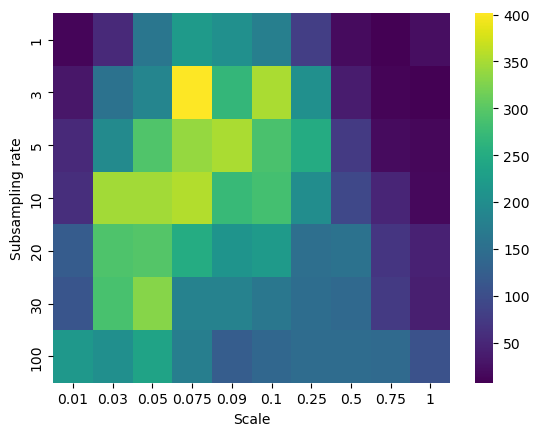

In [ ]:
# Plot heatmap
sns.heatmap(M, cmap='viridis')
plt.xticks(ticks=np.arange(len(scaling_values)) + 0.5, labels=scaling_values)  # Adjust 0.5 offset if needed
plt.yticks(ticks=np.arange(len(subsampling_rate_values)) + 0.5, labels=subsampling_rate_values)  # Adjust 0.5 offset if needed
plt.xlabel('Scale')
plt.ylabel('Subsampling rate')
plt.show()

# See perfomance for 10 samples 

In [68]:
n = 10
random_samples = [ 125,  60,  53,  89,   9,  61, 156,  99,  92, 115] #np.random.choice(np.arange(160), size=n, replace=False)
print('The extracted samples are: ', random_samples)

samples_box = []

for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 
    # set the likelihood
    y_distr_fine= tda.GaussianLogLike(y_observed, cov_likelihood) 
    y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,model_lf)
    my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)
    my_posteriors = [my_posterior_coarse, my_posterior_fine]    
    
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.075) 

    # Perform the MH Algorithm 
    samples = tda.sample(my_posteriors, my_proposal, iterations=3300, n_chains=1, initial_parameters=init_guess,subsampling_rate = 3)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(300, None, 3), groups="posterior")
    # Append the samples to the list
    samples_box.append( [idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ])
    

The extracted samples are:  [125, 60, 53, 89, 9, 61, 156, 99, 92, 115]
[ 0.164034  0.281502 30.758818]
Sampling chain 1/1


Running chain, α_c = 0.460, α_f = 0.22: 100%|██████████| 3300/3300 [00:09<00:00, 332.16it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.464787 -0.34692  29.295773]
Sampling chain 1/1


Running chain, α_c = 0.663, α_f = 0.42: 100%|██████████| 3300/3300 [00:10<00:00, 314.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.391841  0.24583  29.104798]
Sampling chain 1/1


Running chain, α_c = 0.613, α_f = 0.30: 100%|██████████| 3300/3300 [00:11<00:00, 291.33it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.381797  0.116394 29.238688]
Sampling chain 1/1


Running chain, α_c = 0.680, α_f = 0.30: 100%|██████████| 3300/3300 [00:09<00:00, 331.24it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.417828 -0.33801  29.213157]
Sampling chain 1/1


Running chain, α_c = 0.703, α_f = 0.44: 100%|██████████| 3300/3300 [00:10<00:00, 327.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.18104   0.097916 29.566415]
Sampling chain 1/1


Running chain, α_c = 0.683, α_f = 0.37: 100%|██████████| 3300/3300 [00:10<00:00, 318.31it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.339759  0.329625 29.711193]
Sampling chain 1/1


Running chain, α_c = 0.697, α_f = 0.33: 100%|██████████| 3300/3300 [00:10<00:00, 308.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.478572 -0.036052 30.60058 ]
Sampling chain 1/1


Running chain, α_c = 0.710, α_f = 0.30: 100%|██████████| 3300/3300 [00:10<00:00, 311.78it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.270542  0.352424 30.628894]
Sampling chain 1/1


Running chain, α_c = 0.600, α_f = 0.43: 100%|██████████| 3300/3300 [00:10<00:00, 318.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.493409  0.207659 30.163214]
Sampling chain 1/1


Running chain, α_c = 0.693, α_f = 0.34: 100%|██████████| 3300/3300 [00:10<00:00, 313.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


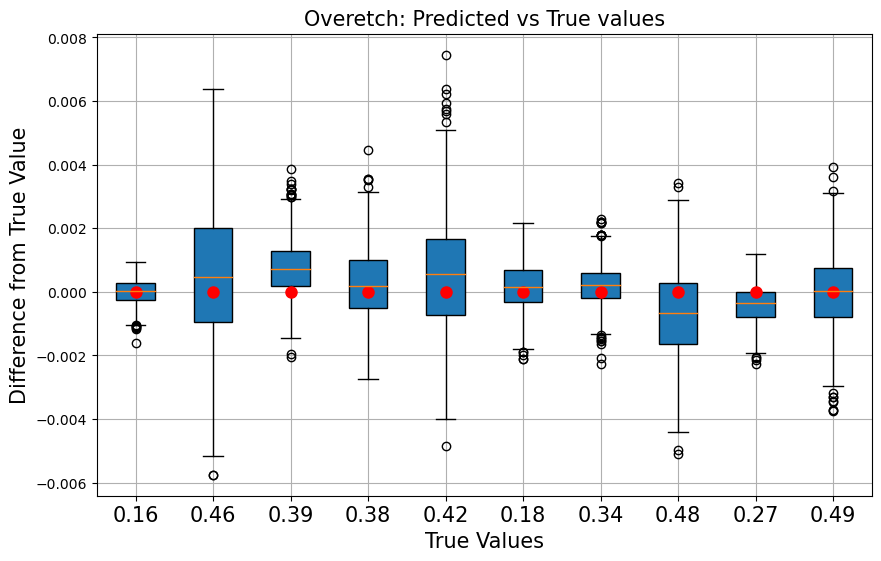

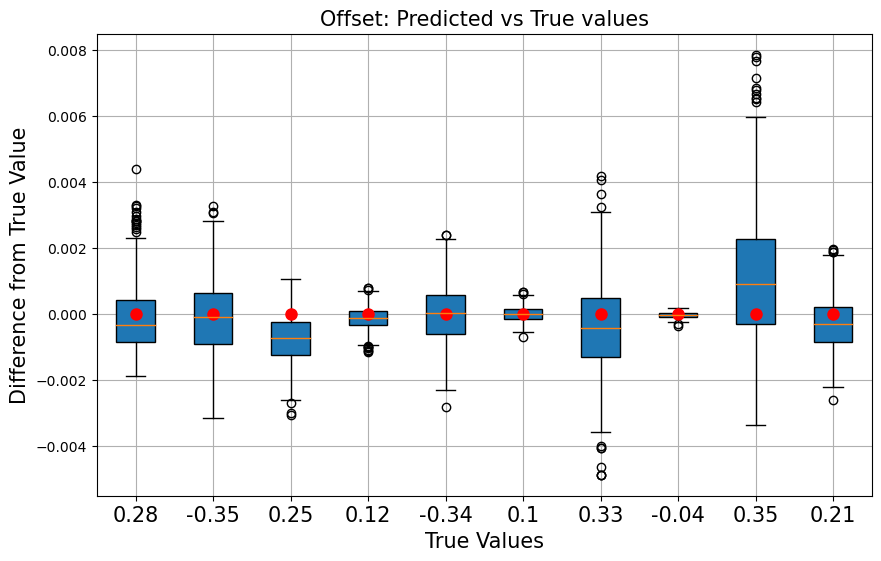

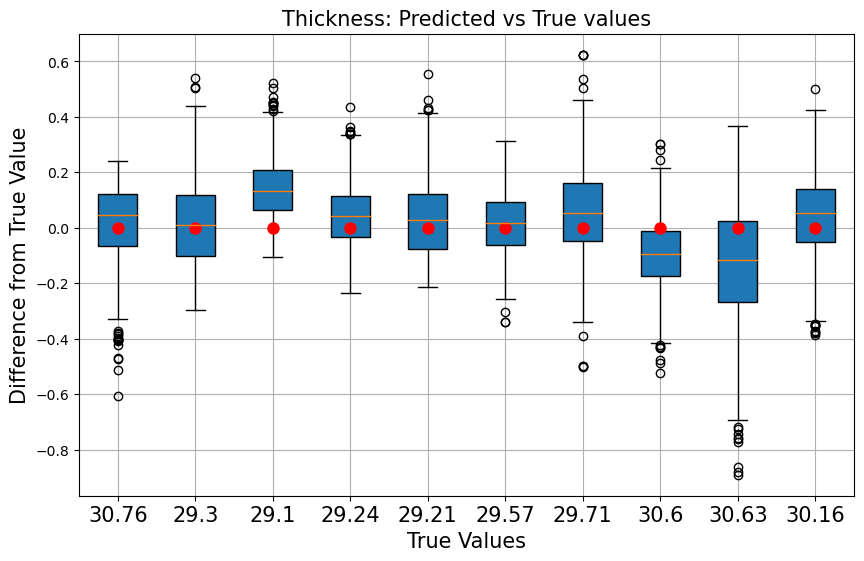

In [69]:
names = ['Overetch', 'Offset', 'Thickness']
for i in range(3):
    #Create a dataset containing all the same parameter samples 
    plot_data = []
    true_val = []
    for j in range(n):
        true_val.append(X_values[random_samples[j]][i])
        plot_data.append(samples_box[j][i]- true_val[j])

    # Plot box plots
    plt.figure(figsize=(10, 6))
    plt.boxplot(plot_data, patch_artist=True)

    # Plot the mean values
    for idx, mean in enumerate(true_val):
        plt.plot(idx + 1, mean*0, 'ro', label='Mean', markersize=8)

    # Add labels and title
    plt.xlabel('True Values',size= 15)
    plt.ylabel('Difference from True Value',size= 15)
    plt.title(names[i] + ': Predicted vs True values',size= 15)
    plt.xticks(np.arange(1, n + 1), np.round(true_val,2), size= 15)
    plt.grid(True)
    plt.show()